# Power law

## Review:
### Power law distribution
* Special kind of probability distribution
$$P(x) = C x^{-\alpha}\quad \text{for} \quad x \geqslant x_{min} > 0$$

where C is a normalization constant makes $\int_{x_{min}}^{\infty} P(x) dx = 1$.

With the help of `sympy` (symbolic python, similiar with symbolic toolbox in matlab), we can find out the value of C

In [ ]:
import sympy
x, C, alpha, xmin = sympy.symbols('x C alpha x_{min}', positive=True)
P = C * x ** (-alpha)
P

C/x**alpha

In [ ]:
integral_result = sympy.integrate(P, (x, xmin, sympy.oo)) # oo refers to infinity
integral_result

Piecewise((C*x_{min}/(x_{min}**alpha*(alpha - 1)), alpha > 1), (Integral(C/x**alpha, (x, x_{min}, oo)), True))

the result shows when $\alpha > 1$, the integral is $\frac{C x_{min}^{1-\alpha}}{\alpha - 1}$, otherwise, this integral is diverge.

In [ ]:
integral_result.args[0]

(C*x_{min}/(x_{min}**alpha*(alpha - 1)), alpha > 1)

In [ ]:
integral_result = integral_result.args[0][0] # get the integral for alpha > 1
sympy.simplify(integral_result)

C*x_{min}**(1 - alpha)/(alpha - 1)

In [ ]:
solution = sympy.solve(integral_result - 1, C)[0] # solve the equation, integral_result - 1 = 0
solution

x_{min}**(alpha - 1)*(alpha - 1)

In [ ]:
P = P.subs(C, solution) # substitude the solution
P = sympy.simplify(P)
P

x_{min}**(alpha - 1)*(alpha - 1)/x**alpha

Finally, we find out $C = (\alpha-1)/x_{min}^{1-\alpha}$

### Moments

The n-th moment of a distribution is : $\left< x^k \right> = \int_{x_{min}}^{\infty} x^k P(x) dx$

In [ ]:
k = sympy.Symbol('k', positive=True)
moments_k = sympy.integrate(P * x ** k, (x, xmin, sympy.oo))
sympy.simplify(moments_k)

Piecewise((x_{min}**k*(1 - alpha)/(-alpha + k + 1), alpha - k > 1), (x_{min}**(alpha - 1)*(alpha - 1)*Integral(x**(-alpha + k), (x, x_{min}, oo)), True))

$$\left< x^k \right> = x^k_{min}\frac{\alpha-1}{\alpha-k-1} \quad \text{for} \quad \alpha > 1 + k$$
otherwise
$$\left< x^k \right> \quad \text{diverge}$$

### Visualize the powerlaw distribution
It's convenient to visualize the powerlaw in log-log scale, as

$$\log{P(x)} = -\alpha \log{x} + \log{C}$$
Using log-log plot, powerlaw will become a straight  line with sloop equal to $-\alpha$

#### From the formula

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def powerlaw(x, alpha, xmin=1):
    assert x.min() >= xmin, f'the minimum x should larger than {xmin}'
    C = xmin ** (alpha-1) * (alpha - 1)
    return C * x** (- alpha)


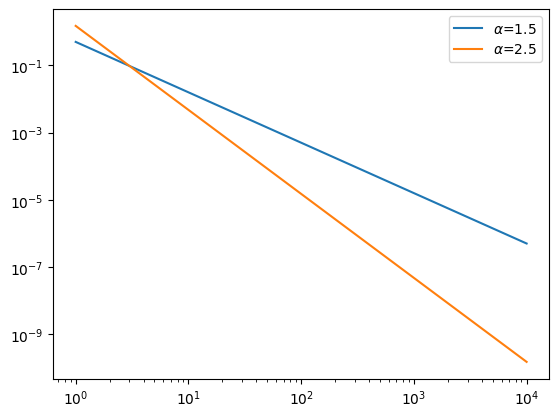

In [3]:
xx = np.linspace(1, 10**4, 100)
plt.plot(xx, powerlaw(xx, 1.5), label=r"$\alpha$=1.5")
plt.plot(xx, powerlaw(xx, 2.5), label=r"$\alpha$=2.5")
plt.xscale('log')
plt.yscale('log')
plt.legend()

#### From random numbers

In scipy.stats module, there is a class: [pareto](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pareto.html#scipy.stats.pareto) to generate Pareto continuous random variable.

> Pareto Distribution: $$P(x, b) = \frac{b}{x^{b+1}}$$ where $x \geqslant 1$ and $b>0$

In [ ]:
from scipy.stats import pareto
b = 0.5 # equivalent to alpha = 1.5
r = pareto.rvs(b, size=10000) # generate 10000 random numbers from pareto distribution

Once we have the random numbers, we can compute the histogram of them by using [numpy.histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)

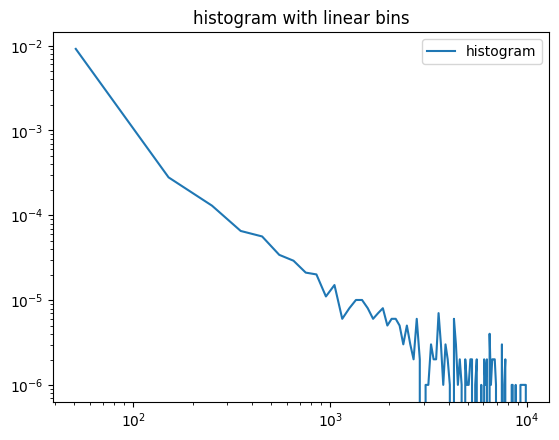

In [ ]:
hist, bin_edges = np.histogram(r, bins=100, range=(1, 10000), density=True)
# with density=True the result is the value of the probability density function at the bin
bin_center = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(bin_center, hist, label='histogram')
plt.title("histogram with linear bins")
plt.legend()
plt.xscale('log')
plt.yscale('log')

The distribution is noisy in the right-hand end of the distribution because of sampling errors.
The power-law distribution dwindles in this region, meaning that each bin only has a few samples in it. So the fractional fluctuations in the bin counts are large and this appears as a noisy curve on the plot.
One way to deal with this is to vary the width of the bins in the histogram. The most common choice is to create bins such that each is a fixed multiple wider the one before it. This is known as `logarithmic binning`.

In [ ]:
b = np.logspace(0, 3, 10)
np.log(b)

array([0.        , 0.76752836, 1.53505673, 2.30258509, 3.07011346,
       3.83764182, 4.60517019, 5.37269855, 6.14022691, 6.90775528])

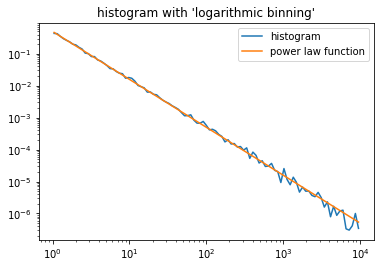

In [ ]:
hist, bin_edges = np.histogram(r, bins=np.logspace(0, 4, 100), density=True)
# with density=True the result is the value of the probability density function at the bin
bin_center = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(bin_center, hist, label='histogram')
plt.plot(bin_center, powerlaw(bin_center, 1.5), label="power law function")
plt.title("histogram with 'logarithmic binning'")
plt.legend()
plt.xscale('log')
plt.yscale('log')

## Fit a power law distribution

### polynomial fit
The simplest way to fit a histogram of power-law distribution is by using a straight line, in other words, fit the relation between log y and log x by a 1 order polynomial.

In [ ]:
p = np.polyfit(np.log(bin_center), np.log(hist), deg=1)
p

array([-1.52637682, -0.6033226 ])

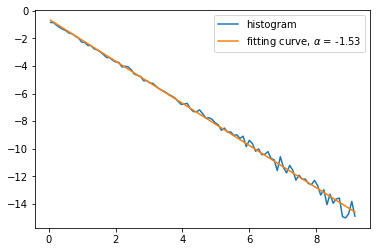

In [ ]:
plt.plot(np.log(bin_center), np.log(hist), label='histogram')
plt.plot(np.log(bin_center), np.log(bin_center) * p[0] + p[1], label=f"fitting curve, $\\alpha$ = {p[0]:.2f}")
plt.legend()

# Maximum likelihood Estimation (MLE)

The simplest way to fit a Pareto distribution by MLE is using pareto.fit() directly

In [ ]:
b, loc, scale = pareto.fit(r, floc=0, fscale=1)
b

0.49984294417611996

In the module scipy.stats, this `fit` function uses Maximum Likelihood Estimation (MLE) as its default estimation method.

[Maximum likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is achieved by maximizing the conditional probability: $L(\theta | y)$, where $\theta$ is the parameter we want to estimate, and y is our observation values. This probability is called likelihood function. In other words, this method is going to find out the most likely $\theta$ under the condition that we have the measurements ${y_1, y_2, y_3, ... y_n}$

$$L(\theta|y) = \prod_n P(y_n; \theta)$$

To find out the maximum value, it's often convenient to work with the natural logarithm of the likelihood function, called log-likelihood:
$$l(\theta|y) = \sum_n \log{ P(y_n; \theta)}$$
Then solve the equation:
$$\frac{\partial l}{\partial \theta}=0$$

So for Power law distribution:
$$P(x; b) = C x^{-\alpha}$$
where $C=(\alpha-1)/x_{min}^{1-\alpha}$

In [ ]:
y = sympy.IndexedBase('y', positive=True)
i, n, b = sympy.symbols('i n b', positive=True)
P = P.subs(x, y[i])
log_L = sympy.Sum(sympy.log(P), (i, 1, n)) # l = sum of log(P(x))
log_L

Sum(log(x_{min}**(alpha - 1)*(alpha - 1)/y[i]**alpha), (i, 1, n))

In [ ]:
dldb = log_L.diff(alpha)
dldb

Sum(x_{min}**(1 - alpha)*(x_{min}**(alpha - 1)*(alpha - 1)*log(x_{min})/y[i]**alpha - x_{min}**(alpha - 1)*(alpha - 1)*log(y[i])/y[i]**alpha + x_{min}**(alpha - 1)/y[i]**alpha)*y[i]**alpha/(alpha - 1), (i, 1, n))

In [ ]:
dldb = log_L.diff(alpha)
dldb = sympy.simplify(dldb * (alpha-1))
dldb

n*(alpha - 1)*log(x_{min}) + n + (1 - alpha)*Sum(log(y[i]), (i, 1, n))

So:
$$\frac{\partial l}{\partial b}=0$$
$$n(\alpha-1)\log{x_{min}}+n+(1-\alpha)\sum_i \log{y_i} = 0$$

In [ ]:
sympy.solve(dldb, alpha)[0]

(n*log(x_{min}) - n - Sum(log(y[i]), (i, 1, n)))/(n*log(x_{min}) - Sum(log(y[i]), (i, 1, n)))

Finally we get:
$$\alpha = \frac{n\log{x_{min}-n-\sum_i\log{y_i}}}{n\log{x_{min}-\sum_i \log{y_i}}} = 1 + \frac{n}{\sum_i\log{y_i}-n\log{x_{min}}}$$

With maximum likelihood, we can get Akaike information criterion (AIC), which is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.

## Exercise 01
 ***1.	Ask ChatGPT to write a 150-200 word summary on an application of power law distribution and then comment/evaluate this answer in your own words in 3-4 sentences based on what you have learned in class. Please also copy the ChatGPT output into the notebook.***

INPUT:  
write a 150-200 word summary on the application of power law distribution for the airports.  
#-----------------------------#
OUTPUT:  
Power law distributions are integral to understanding and optimizing airport operations, particularly in analyzing passenger and flight traffic patterns. This distribution typically reveals that a small number of airports handle a vast majority of flights and passengers, while most others manage comparatively fewer. Recognizing this pattern is essential for effective resource allocation and infrastructure planning.

For instance, major hubs like Atlanta's Hartsfield-Jackson or London Heathrow handle disproportionately high traffic volumes. By understanding these patterns, airport authorities can better plan for capacity enhancements, security staffing, and gate assignments to accommodate peak traffic efficiently. This helps in minimizing bottlenecks and ensuring smoother operations.

Additionally, power law distributions assist in managing the impact of delays and disruptions. Since delays at major hubs can have cascading effects on global networks, airports can develop more robust contingency plans and allocate resources more effectively to mitigate these impacts.

Moreover, power law insights aid in strategic investment decisions. Airports can prioritize upgrades and expansions where they will have the most significant impact on overall network efficiency. This application ultimately enhances operational resilience, improves passenger experience, and supports the growth of the global aviation network.
#-----------------------------#
COMMENT:  
The distribution of airports in the real world, such as in the US, follows a power law distribution. Most airports tend to have a small number of airlines connected to them, while a few airports, such as the one in Dallas, Texas, have a large number of airlines connected to them. The answer generated by ChatGPT also reveals this fact by pointing out the existence of hubs. It elucidates the importance of the power law distributions, as delays at major hubs can significantly impact the whole network. This inspires us to pay attention to entities that appear at the tail of a power law distribution.

***2.Reproduce all three figures on slide 9 using $\alpha$=1.6,2.2 and 3.1.***
> generate random numbers by using scipy.stats.pareto.rvs(b, size)

> make a log-log plot

> If first and/or second moments exist, draw the theoretical value as dashed line.

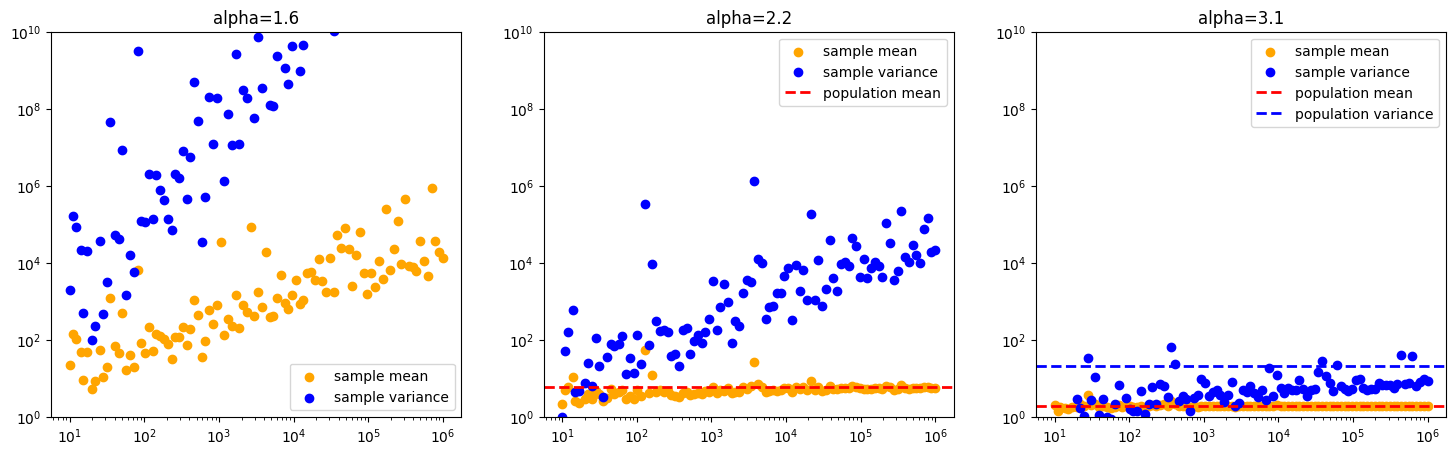

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pareto

def samples(alpha, size=100):
  b = alpha - 1
  r = pareto.rvs(b, size=size)

  sample_mean = np.mean(r)
  sample_variance = np.var(r)
  
  return sample_mean, sample_variance

sizes = np.logspace(1, 6, 100).astype(int)

def population_mean(alpha,r):
  mean = np.min(r) * (alpha - 1) / (alpha - 1 - 1)
  return mean

def population_var(alpha, r):
  variance = np.min(r) * (alpha - 1) / (alpha - 1 - 2)
  return variance


def stats(alpha, sizes):

  
  sample_mean_all, sample_variance_all = [], []
  for size in sizes:
    r = pareto.rvs(alpha - 1, size=size)

    sample_mean_all.append(np.mean(r))
    sample_variance_all.append(np.var(r))
  
  pop_mean = population_mean(alpha,r) if alpha > 1+1 else None
  pop_var = population_var(alpha,r) if alpha > 1+2 else None
  return sample_mean_all, sample_variance_all, pop_mean, pop_var

plt.figure(figsize=(18, 5))
for i, alpha in enumerate([1.6, 2.2, 3.1]):
  sample_mean_all, sample_variance_all, pop_mean, pop_var = stats(alpha, sizes)
  plt.subplot(1, 3, i+1)
  plt.scatter(sizes, sample_mean_all, label='sample mean', color='orange')
  plt.scatter(sizes, sample_variance_all, label='sample variance',color='blue')
  if pop_mean:
    plt.axhline(pop_mean, color='r', linestyle='--', label='population mean', linewidth=2)
  if pop_var:
    plt.axhline(pop_var, color='b', linestyle='--', label='population variance', linewidth=2)
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()
  plt.title(f'alpha={alpha}')
  plt.ylim(1e-0, 1e10)






***3.Reproduce Zipf's law through sample-space-reducing (SSR) processes; fit the histogram to determine the power-law exponent.***

**SSR processes**
 A ball starts at the highest state $i=N$, and may sequentially jump randomly toward any lower state. Once the ball hits the lowest state $i=1$ the process starts again at state $N$. If repeated many times, the probability of visiting states is an exact Zipf's law, $P(i) = \frac{c}{i}$

<!-- The simple sample space reducing (SSR) process could be illustrated by a set of N fair dice with different number of faces. The first has one face, the second has two faces and so on to the N-th that has N faces. To start the process we take the dice with N faces and throw it, getting a result K. Then we throw the dice with K-1 faces getting a new result. Once we reach the dice with one face we restart the process by throwing the N-faced dice again. In an equivalent way, we can interpret the process considering a staircase with N steps: imagine a ball that randomly falls downstairs but never can climb to higher levels. The ball first hits any of the N steps with uniform probability, $P_N(i)=1/N$
, $i=1\dots N$
. Then it can only fall down to a lower level with uniform probability and so on until it reaches the bottom step. Once landed on the first step, it restart jumping randomly to any of the steps. -->
![SSR](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-017-09836-4/MediaObjects/41598_2017_9836_Fig1_HTML.jpg?as=webp)
> Fig 1 in : Corominas-Murtra, B., Hanel, R. & Thurner, S. Sample space reducing cascading processes produce the full spectrum of scaling exponents. Sci Rep 7, 11223 (2017).


**Fit the histogram**
For checking whether your result obeys $P(i) = \frac{c}{i}$ or not, please find the exponent by polynomial fit.

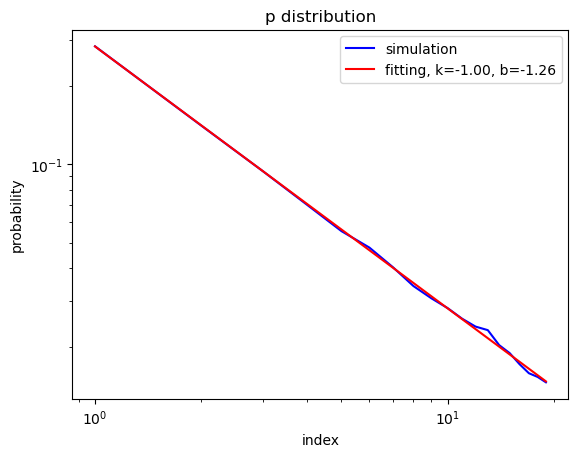

In [28]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def choose_number_infront(i):
  '''
  Choose a number randomly from 1 to i-1
  i: current index
  '''
  return np.random.choice(np.arange(1, i))

index = 20
tot_index = []

for _ in range(10000):
  while index != 1:
    index = choose_number_infront(index)
    tot_index.append(index)
  index = 20
tot_index = np.array(tot_index)
p = np.bincount(tot_index) / len(tot_index)
x = np.arange(1, 20)


# Zipf distribution fitting
def zipf_fitting(x, y):
  k, b = np.polyfit(np.log(x), np.log(y), deg=1)
  return x**(k) * np.exp(b), k, b

fitted_curve, k, b =  zipf_fitting(x, p[1:])

plt.plot(x, p[1:], 'b', label='simulation')
plt.plot(x, fitted_curve, 'r', label=f'fitting, k={k:.2f}, b={b:.2f}')
plt.xlabel('index')
plt.ylabel('probability')
plt.title('p distribution')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


